In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import learning_curve
import re

In [3]:
df=pd.read_csv('data.csv')
df.head()

,id,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
df.shape

(699, 11)

In [5]:
df = df.drop(columns='Bare_Nuclei')
df = df.drop(columns='id')

In [6]:
df.head()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5,1,1,1,2,3,1,1,2
1,5,4,4,5,7,3,2,1,2
2,3,1,1,1,2,3,1,1,2
3,6,8,8,1,3,3,7,1,2
4,4,1,1,3,2,3,1,1,2


In [7]:
df.shape

(699, 9)

In [8]:
df.describe()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [9]:
print(df.groupby('Class').size())

Class
2    458
4    241
dtype: int64


In [11]:
df['Class'][df['Class'] == 4] = 1 
df['Class'][df['Class'] == 2] = 0

In [12]:
print(df.groupby('Class').size())

Class
0    458
1    241
dtype: int64


In [13]:
cor=df.corr()


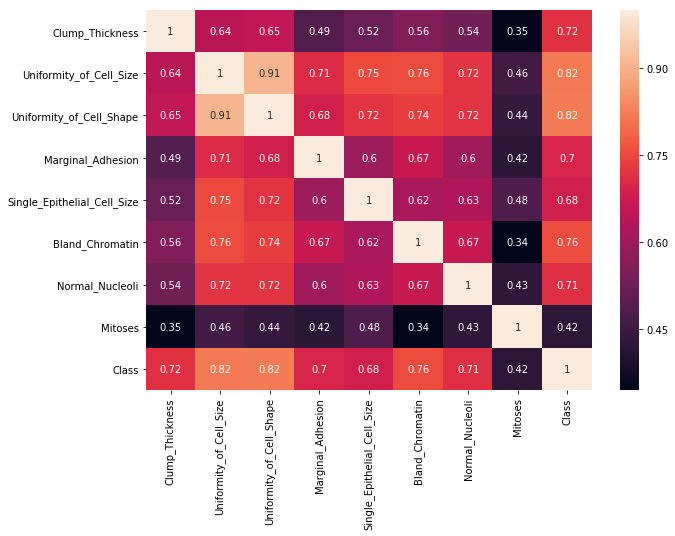

In [14]:
plt.figure(figsize = (10,7))
sns.heatmap(cor, annot=True)

<module 'matplotlib.pyplot' from 'C:\\Users\\LENOVO\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

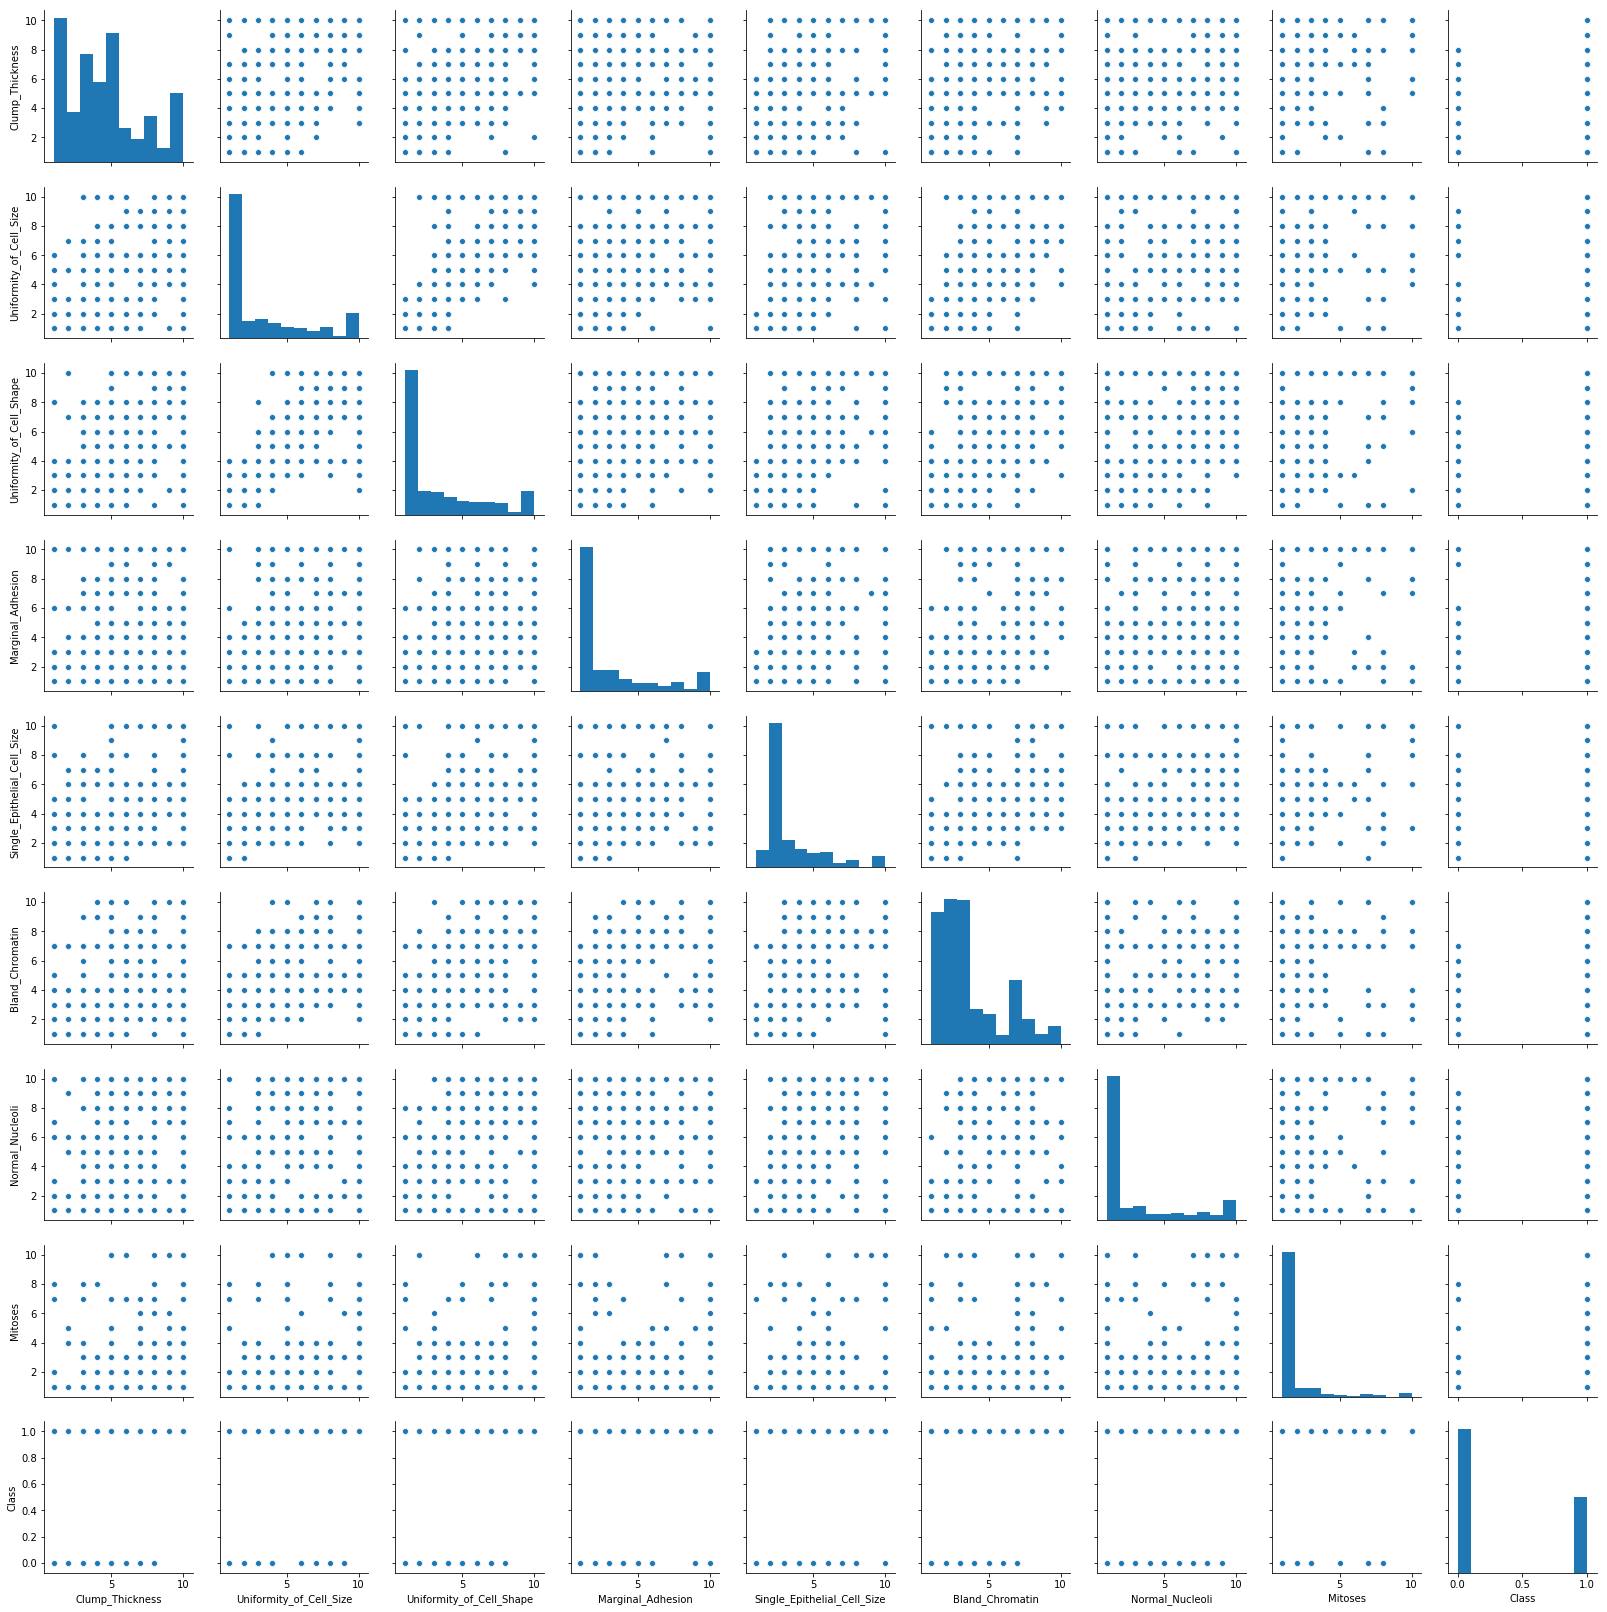

In [44]:
sns.pairplot(df,dropna=True)
plt

In [15]:
X = df.drop(columns=['Class'],axis=1).values
y = df['Class']

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [17]:
x = pd.DataFrame(X)

In [18]:
from sklearn import metrics

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [20]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [52]:
#X_test = scaler.transform(X_test)

In [63]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
clf.score(X_test,y_test)

0.9571428571428572

In [64]:
col=df.drop(columns='Class')
col.columns

Index(['Clump_Thickness', 'Uniformity_of_Cell_Size',
       'Uniformity_of_Cell_Shape', 'Marginal_Adhesion',
       'Single_Epithelial_Cell_Size', 'Bland_Chromatin', 'Normal_Nucleoli',
       'Mitoses'],
      dtype='object')

In [ ]:
import pydotplus
import os     
from ipywidgets import Image
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
dot_data = StringIO()
export_graphviz(clf, feature_names = col.columns, out_file=dot_data,
                filled=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())
graph.write_png("mushrooms.png")


In [65]:
precision = metrics.precision_score(y_test,y_pred,average='weighted')
print('Точность:',precision)

Точность: 0.9571428571428572


In [66]:
recall = metrics.recall_score(y_test,y_pred)
print('Полнота:',recall)

Полнота: 0.9333333333333333


In [23]:
from sklearn.metrics import confusion_matrix
#confusion_matrix=confusion_matrix(y_test,y_pred)

In [24]:
# Матрица ошибок
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "10"],
                  columns = [i for i in "10"])
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20})

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<Figure size 576x432 with 0 Axes>

In [25]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

NameError: name 'y_pred' is not defined

Text(0.5, 0, 'False Positive Rate')

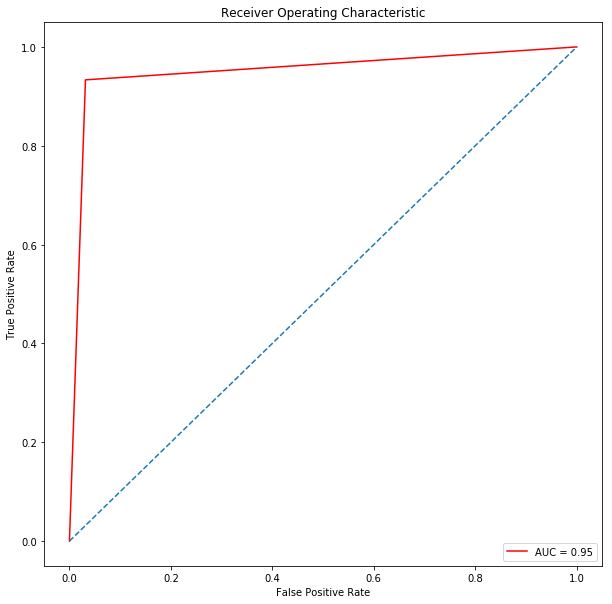

In [30]:
# Строим ееееееее рок кривую 

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
# ПОКА НЕ РАБОТЕТ
from sklearn.tree import export_graphviz
from io import StringIO
import graphviz
import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
dot_data = StringIO()
export_graphviz(clf, feature_names = x.columns, out_file=dot_data,
                filled=True) 
graph = graphviz.Source(dot_data)  
graph 

In [27]:
#Посотроим базовую модель машины опорных векторов
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

In [49]:
svc = SVC(class_weight='balanced',random_state=42)
svc

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [50]:
svc.fit(X_train,y_train)
svc.predict(X_test)
svc.score(X_test,y_test)

0.9571428571428572

In [51]:
#Попробуем улучшить показатели засчет оптимизации гиперпараметров

parameters = {
    'C': [10.,1.,0.1,0.01,0.001],
    'kernel': ['linear','poly','rbf','sigmoid'],
    'gamma': ['scale','auto_deprecated']
}

In [52]:
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

In [53]:
gridSearch = GridSearchCV(svc,parameters,n_jobs=-1,scoring='roc_auc',cv=skf,verbose=10)
gridSearch = gridSearch.fit(X_train,y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1954s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1200s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.3min finished


In [54]:
gridSearch.best_estimator_

SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
best_model_csv = gridSearch.best_score_
best_model_csv


0.9907624082042686

In [56]:
svc_tuned = SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
svc_tuned.fit(X_train,y_train)


SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [57]:
y_pred = svc_tuned.predict(X_test)
svc_tuned.score(X_test,y_test)

0.9642857142857143

In [60]:
precision = metrics.precision_score(y_test,y_pred,average='weighted')
print('Точность:',precision)

Точность: 0.9645995771111405


In [61]:
recall = metrics.recall_score(y_test,y_pred)
print('Полнота:',recall)

Полнота: 0.9555555555555556


In [196]:
#confusion_matrix(y_test,y_pred)

In [64]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

In [67]:
%%time
bag = BaggingClassifier(SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))
randgs = RandomizedSearchCV(bag, parameters,n_jobs=-1,scoring='roc_auc',cv=skf,n_iter=20,random_state=1,verbose=10)
randgs = randgs.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.1s


Wall time: 4.67 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished


In [68]:
randgs.best_score_

0.9906624659461183

In [69]:
randgs.best_estimator_

BaggingClassifier(base_estimator=SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=3,
         max_samples=0.7, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [215]:
bc = BaggingClassifier(base_estimator=SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=3,
         max_samples=0.7, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [227]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [217]:
bc.fit(X_train,y_train)

BaggingClassifier(base_estimator=SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=3,
         max_samples=0.7, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [218]:
y_pred_bc = bc.predict(X_test)

In [219]:
y_pred_bc

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [220]:
bc.score(X_test,y_test)

0.9642857142857143

In [221]:


precision = metrics.precision_score(y_test,y_pred_bc,average='weighted')
print('Точность:',precision)

Точность: 0.9657256160891324


In [222]:
recall = metrics.recall_score(y_test,y_pred_bc)
print('Полнота:',recall)

Полнота: 0.9791666666666666


In [223]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_bc)
cm


array([[88,  4],
       [ 1, 47]], dtype=int64)

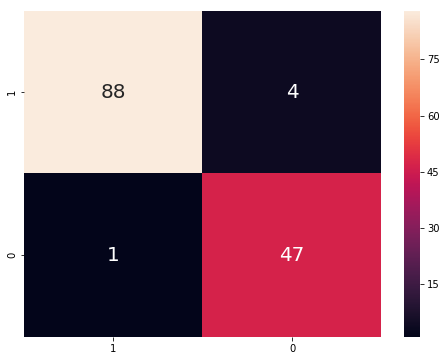

In [194]:
# Матрица ошибок
df_cm = pd.DataFrame(cm, index = [i for i in "10"],
                  columns = [i for i in "10"])
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20})

In [103]:
# Нам удалось добиться улучшения в три наблюдения,
#которые ранее были классифицированы ошибочно как ложно отрицательные

In [224]:
import xgboost

In [237]:
xgb = xgboost.XGBClassifier()
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [228]:
xgb.fit(X_train,y_train)
xgb.predict(X_test)
xgb.score(X_test,y_test)

0.9642857142857143

In [232]:
parameters = {
    'learning_rate':[10.,1.,0.1,0.001],
    'max_depth':[3,6,8],
    'gamma': [ 0.0, 0.1, 0.2],
    'colsample_bytree' : [ 0.3, 0.4, 0.5],
    'booster': ['gbtree','gblinear']
}


In [233]:
xgbGrid = GridSearchCV(xgb,parameters,n_jobs=-1,scoring='roc_auc',cv=skf,verbose=10)
xgbGrid = xgbGrid.fit(X_train,y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1978s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 203 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 237 tas

In [234]:
xgbGrid.best_score_

0.9920797307042958

In [235]:
xgbGrid.best_estimator_

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0.0, learning_rate=1.0,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [341]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [342]:
xgb_tuned = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=10.0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=5,
       reg_lambda=5, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [343]:
xgb_tuned.fit(X_train,y_train)
y_pred_xgb = xgb_tuned.predict(X_test)
xgb_tuned.score(X_test,y_test)

0.9714285714285714

In [344]:
recall = metrics.recall_score(y_test,y_pred_xgb)
print('Полнота:',recall)

precision = metrics.precision_score(y_test,y_pred_xgb,average='weighted')
print('Точность:',precision)

Полнота: 0.9791666666666666
Точность: 0.9721269841269843


In [345]:
from sklearn.metrics import confusion_matrix
cmg = confusion_matrix(y_test,y_pred_xgb)
cmg


array([[89,  3],
       [ 1, 47]], dtype=int64)

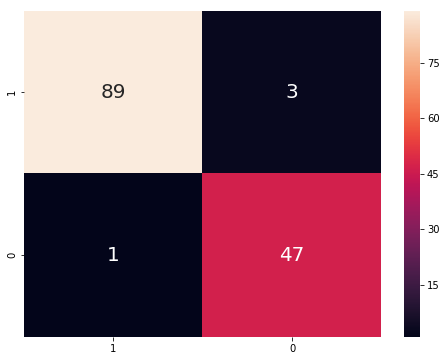

In [346]:
# Матрица ошибок
df_cmg = pd.DataFrame(cmg, index = [i for i in "10"],
                  columns = [i for i in "10"])
plt.figure(figsize = (8,6))
sns.heatmap(df_cmg, annot=True,annot_kws={"size": 20})

In [347]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_xgb)
roc_auc = auc(false_positive_rate, true_positive_rate)

Text(0.5, 0, 'False Positive Rate')

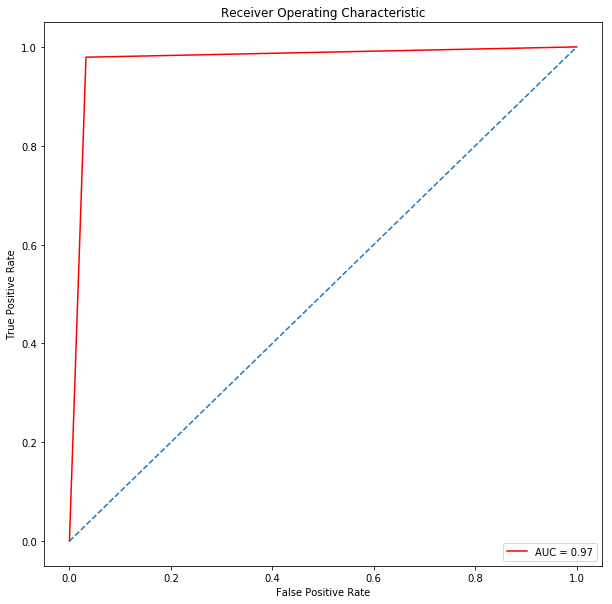

In [348]:
# Строим ееееееее рок кривую 

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [89]:
# Рандом форест 
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred_rfc = rfc.predict(X_test)
rfc.score(X_test,y_test)


C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9642857142857143

In [82]:
parameters = {
    'max_depth':[8,20],
    'n_estimators':[50,100,500],
    'max_features':[1, 2, 4], 
    'min_samples_leaf': [3, 9]
}

In [83]:
rfc_tuned = GridSearchCV(rfc,parameters,n_jobs=-1,scoring='roc_auc',cv=skf,verbose=10)
rfc_tuned = rfc_tuned.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

In [84]:
rfc_tuned.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [87]:
rfc_tuned = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
            max_depth=100, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
rfc_tuned.fit(X_train,y_train)
y_pred_rfc = rfc_tuned.predict(X_test)
rfc_tuned.score(X_test,y_test)

0.9785714285714285

In [91]:
recall = metrics.recall_score(y_test,y_pred_rfc)
print('Полнота:',recall)

precision = metrics.precision_score(y_test,y_pred_rfc,average='weighted')
print('Точность:',precision)

Полнота: 0.9111111111111111
Точность: 0.9646501457725947


In [92]:
from sklearn.metrics import confusion_matrix
cmg = confusion_matrix(y_test,y_pred_rfc)
cmg


array([[94,  1],
       [ 4, 41]], dtype=int64)

In [93]:
y_pred_rfc

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0], dtype=int64)

In [21]:
from catboost import CatBoostClassifier

In [31]:
cb = CatBoostClassifier(learning_rate=0.1,iterations=5)
cb.fit(X_train,y_train)
cb.predict(X_test)
cb.score(X_test,y_test)

0:	learn: 0.5287124	total: 635ms	remaining: 2.54s
1:	learn: 0.4195558	total: 691ms	remaining: 1.04s
2:	learn: 0.3397047	total: 747ms	remaining: 498ms
3:	learn: 0.2838342	total: 792ms	remaining: 198ms
4:	learn: 0.2321259	total: 849ms	remaining: 0us


0.9714285714285714

In [28]:
CatBoostClassifier?

Init signature:
CatBoostClassifier(
    ['iterations=None', 'learning_rate=None', 'depth=None', 'l2_leaf_reg=None', 'model_size_reg=None', 'rsm=None', "loss_function='Logloss'", 'border_count=None', 'feature_border_type=None', 'input_borders=None', 'output_borders=None', 'fold_permutation_block=None', 'od_pval=None', 'od_wait=None', 'od_type=None', 'nan_mode=None', 'counter_calc_method=None', 'leaf_estimation_iterations=None', 'leaf_estimation_method=None', 'thread_count=None', 'random_seed=None', 'use_best_model=None', 'best_model_min_trees=None', 'verbose=None', 'silent=None', 'logging_level=None', 'metric_period=None', 'ctr_leaf_count_limit=None', 'store_all_simple_ctr=None', 'max_ctr_complexity=None', 'has_time=None', 'allow_const_label=None', 'classes_count=None', 'class_weights=None', 'class_names=None', 'one_hot_max_size=None', 'random_strength=None', 'name=None', 'ignored_features=None', 'train_dir=None', 'custom_loss=None', 'custom_metric=None', 'eval_metric=None', 'bagging_te

In [32]:
params = {
    'iterations': [5,7,10],
    'learning_rate': [0.01,0.1,1],
    'depth': [3,6,9] 
}

In [33]:
cb_tuned = GridSearchCV(cb,params,n_jobs=-1,scoring='roc_auc',cv=skf,verbose=10)
cb_tuned = cb_tuned.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  2.1min finished


0:	learn: 0.6749004	total: 107ms	remaining: 644ms
1:	learn: 0.6556790	total: 248ms	remaining: 621ms
2:	learn: 0.6379727	total: 546ms	remaining: 728ms
3:	learn: 0.6211316	total: 704ms	remaining: 528ms
4:	learn: 0.6050371	total: 869ms	remaining: 348ms
5:	learn: 0.5896686	total: 1.03s	remaining: 172ms
6:	learn: 0.5738834	total: 1.09s	remaining: 0us


In [34]:
cb_tuned.best_score_

0.98935128546531

In [40]:
cb_tuned.best_estimator_

In [35]:
y_pred_cb=cb_tuned.predict(X_test)
cb_tuned.score(X_test,y_test)


0.9971929824561404

In [48]:
cm = confusion_matrix(y_test,y_pred_cb)
cm

array([[93,  2],
       [ 2, 43]], dtype=int64)

In [41]:
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

In [42]:
# рисуем кривую обучения
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\LENOVO\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

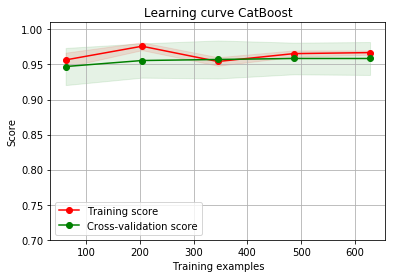

In [43]:
title = 'Learning curve CatBoost'
estimator = cb_tuned.best_estimator_

plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=skf, n_jobs=4)

In [58]:
from sklearn.ensemble import AdaBoostClassifier

In [66]:
abc = AdaBoostClassifier(estimator,10,0.1,'SAMME')

In [67]:
abc.fit(X_train,y_train)
abc.predict(X_test)
abc.score(X_test,y_test)

0:	learn: 0.6734263	total: 71.8ms	remaining: 431ms
1:	learn: 0.6566030	total: 144ms	remaining: 360ms
2:	learn: 0.6366234	total: 233ms	remaining: 310ms
3:	learn: 0.6200667	total: 313ms	remaining: 235ms
4:	learn: 0.6020806	total: 396ms	remaining: 158ms
5:	learn: 0.5861340	total: 463ms	remaining: 77.2ms
6:	learn: 0.5748320	total: 526ms	remaining: 0us
0:	learn: 0.6738020	total: 78.4ms	remaining: 470ms
1:	learn: 0.6558288	total: 159ms	remaining: 399ms
2:	learn: 0.6408029	total: 217ms	remaining: 290ms
3:	learn: 0.6233184	total: 309ms	remaining: 232ms
4:	learn: 0.6066236	total: 387ms	remaining: 155ms
5:	learn: 0.5917537	total: 452ms	remaining: 75.3ms
6:	learn: 0.5773854	total: 506ms	remaining: 0us
0:	learn: 0.6751894	total: 108ms	remaining: 649ms
1:	learn: 0.6603225	total: 204ms	remaining: 509ms
2:	learn: 0.6438843	total: 276ms	remaining: 368ms
3:	learn: 0.6281196	total: 353ms	remaining: 265ms
4:	learn: 0.6145225	total: 433ms	remaining: 173ms
5:	learn: 0.6012472	total: 509ms	remaining: 84.8ms

0.9571428571428572